In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import warnings

warnings.filterwarnings("ignore")

In [2]:
from util import silhouette_plot, cluster_stability
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

In [3]:
df_main = pd.read_csv("zip_code_age_lg_wealth_osm_percentage.csv", index_col="Unnamed: 0")
df_main = df_main.drop(index=10020)  # missing all the data
df_main.head()

,female[0-9],male[0-9],female[10-19],male[10-19],female[20-29],male[20-29],female[30-39],male[30-39],female[40-49],male[40-49],...,"50,000-75,000","75,000-100,000","100,000-200,000","200,000-...",stadium_count,shoes_count,restaurant_count,gym_count,clothes_count,clinic_count
10026,0.059201,0.056966,0.058436,0.059289,0.094345,0.081110,0.092021,0.078905,0.083287,0.079199,...,0.136957,0.078261,0.100000,0.053261,0.0,0.0,18.0,0.0,0.0,1.0
10027,0.050966,0.050011,0.077194,0.067228,0.131140,0.108530,0.077478,0.069054,0.066776,0.061601,...,0.126863,0.064340,0.086514,0.046529,0.0,2.0,25.0,4.0,5.0,1.0
10030,0.061002,0.062484,0.070706,0.071484,0.096892,0.080744,0.081522,0.067521,0.081929,0.070929,...,0.128168,0.052860,0.047791,0.013034,0.0,0.0,6.0,1.0,0.0,0.0
10037,0.049150,0.049265,0.056213,0.057648,0.085209,0.068098,0.081477,0.056442,0.081994,0.060232,...,0.176362,0.093259,0.084026,0.012004,0.0,0.0,2.0,1.0,0.0,0.0
10039,0.066172,0.070494,0.073715,0.072940,0.085905,0.075142,0.083541,0.066172,0.079097,0.066090,...,0.128866,0.055228,0.050074,0.011782,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
for osm in ['stadium', 'shoes', 'restaurant', 'gym', 'clothes', 'clinic']:
    col_name = f'{osm}_count'
    sparsity = np.sum(df_main[col_name]==0) / df_main.shape[0]
    print(f'{osm} sparsity: {sparsity}')

stadium sparsity: 0.9193548387096774
shoes sparsity: 0.43548387096774194
restaurant sparsity: 0.04838709677419355
gym sparsity: 0.5
clothes sparsity: 0.3870967741935484
clinic sparsity: 0.43548387096774194


In [5]:
mask = df_main.columns[df_main.columns!='stadium_count']
df_main = df_main[mask]
df_main.shape

(62, 26)

In [6]:
df_main.columns

Index(['female[0-9]', 'male[0-9]', 'female[10-19]', 'male[10-19]',
       'female[20-29]', 'male[20-29]', 'female[30-39]', 'male[30-39]',
       'female[40-49]', 'male[40-49]', 'female[50-59]', 'male[50-59]',
       'female[60-102]', 'male[60-102]', 'population', '1-25,000',
       '25,000-50,000', '50,000-75,000', '75,000-100,000', '100,000-200,000',
       '200,000-...', 'shoes_count', 'restaurant_count', 'gym_count',
       'clothes_count', 'clinic_count'],
      dtype='object')

In [7]:
df_main['shoes_count'] = df_main['shoes_count']/df_main['population']
df_main['restaurant_count'] = df_main['restaurant_count']/df_main['population']
df_main['gym_count'] = df_main['gym_count']/df_main['population']
df_main['clothes_count'] = df_main['clothes_count']/df_main['population']
df_main['clinic_count'] = df_main['clinic_count']/df_main['population']

In [8]:
sc = StandardScaler()
df_main['population'] = sc.fit_transform(df_main[['population']])

### Dendrogram

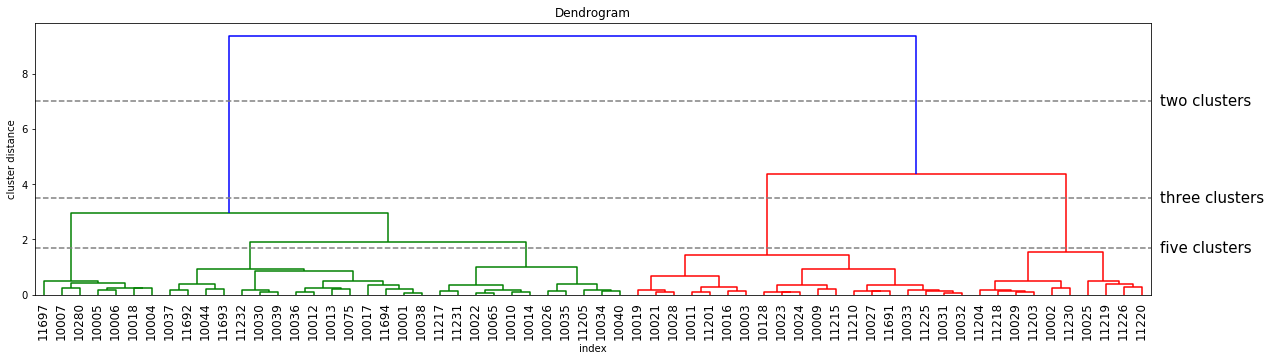

In [9]:
plt.figure(figsize=(20, 5))
linkage_array = ward(df_main)
dendrogram(linkage_array, leaf_font_size=12)

h_line = [7, 3.5, 1.7]

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [h_line[0], h_line[0]], '--', c='grey')
ax.plot(bounds, [h_line[1], h_line[1]], '--', c='grey')
ax.plot(bounds, [h_line[2], h_line[2]], '--', c='grey')

ax.text(bounds[1]+5, h_line[0], 'two clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[1], 'three clusters', va='center', fontdict={'size': 15})
ax.text(bounds[1]+5, h_line[2], 'five clusters', va='center', fontdict={'size': 15})

ax.set_xlabel("index")
ax.set_ylabel("cluster distance")
ax.set_xticklabels([df_main.index[int(i.get_text())] for i in ax.get_xticklabels()])
ax.set_title("Dendrogram")
plt.show()

In [10]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples,adjusted_rand_score
from sklearn.base import clone

In [11]:
params = {"n_clusters": [3, 4, 5, 6]}
cv = 20
for n in params["n_clusters"]:
    scores = list()
    for _ in range(cv):
        base_km = KMeans(n_clusters=n)
        base_km.fit(df_main)
        scores.append(silhouette_score(df_main, base_km.labels_))
    _, s2 = cluster_stability(df_main, KMeans(n_clusters=n), n_iter=cv)
    print(f"N: {n} | silhouette: {np.mean(scores):.4f} | stability: {s2:.4f}")

N: 3 | silhouette: 0.5267 | stability: 0.7203
N: 4 | silhouette: 0.4808 | stability: 0.7902
N: 5 | silhouette: 0.4521 | stability: 0.7106
N: 6 | silhouette: 0.4465 | stability: 0.6655


## Gradient Descent

In [12]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_main)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

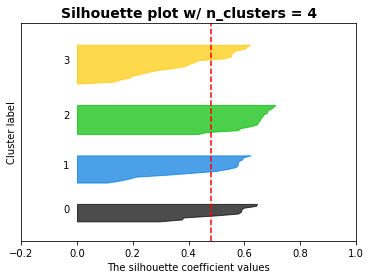

In [13]:
silhouette_plot(df_main, kmeans.labels_, 4, score=0.4808)

In [14]:
from scipy.spatial.distance import cdist, pdist
from shapely.geometry import LineString, Point

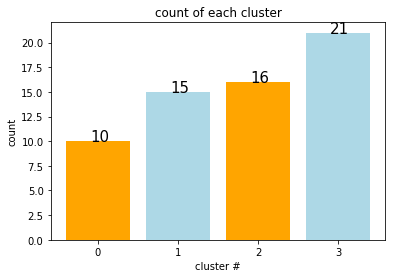

In [15]:
count = Counter(kmeans.labels_)
x_cluster, y_height = zip(*count.items())

plt.bar(x=x_cluster, height=y_height, tick_label=x_cluster, color=["lightblue", "orange"])
for i, j in count.items(): plt.text(x=i-.1, y=j, s=j, fontdict={"fontsize": 15})
plt.ylabel("count")
plt.xlabel("cluster #")
plt.title("count of each cluster")
plt.show()

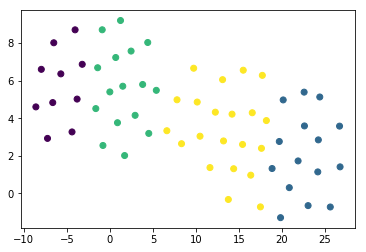

In [17]:
tsne_embedded = TSNE(n_components=2).fit_transform(df_main)
labels_km4 = kmeans.labels_
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=labels_km4)
plt.show()

In [18]:
C = [kmeans.labels_==0,
     kmeans.labels_==1,
     kmeans.labels_==2,
     kmeans.labels_==3]

In [19]:
cluster_zip_code = {i: df_main[c].index for i, c in enumerate(C)}
"Cluster's Zip Code", cluster_zip_code

("Cluster's Zip Code",
 {0: Int64Index([10029, 10002, 10025, 11204, 11218, 11219, 11230, 11203, 11226,
              11220],
             dtype='int64'),
  1: Int64Index([10037, 10001, 10018, 10017, 10004, 10005, 10006, 10007, 10038,
              10280, 10044, 11692, 11693, 11694, 11697],
             dtype='int64'),
  2: Int64Index([10027, 10011, 10016, 10003, 10009, 10128, 10023, 10024, 10031,
              10032, 10033, 11691, 11201, 11215, 11210, 11225],
             dtype='int64'),
  3: Int64Index([10026, 10030, 10039, 10019, 10036, 10035, 10010, 10022, 10012,
              10013, 10014, 10021, 10028, 10065, 10075, 10034, 10040, 11205,
              11217, 11231, 11232],
             dtype='int64')})